# Steel Yield Strenght Prediction and EDA

## The objective of this Notebook trying to predict the Yield Strenght of the steel with its composition.

# Dataset

This dataset represent 312 steels with different composition. Each column represent:
* **formula** - Formula of steel
* **c** - Carbon content (%)
* **mn** - Manganese content (%)
* **si** - Silicone content (%)
* **cr** - Chromium content (%)
* **ni** - Nickel content (%)
* **mo** - Molybdenum content (%)
* **v** - Vanadium content (%)
* **n** - Nitrogen content (%)
* **nb** - Niobium content (%)
* **co** - Cobalt content (%)
* **w** - Tungsten content (%)
* **al** - Aluminium content (%)
* **ti** - Titanium content (%)
* **yield strength** - Yield strength
* **tensile strength** - Tensile strength
* **elongation** - Elongation

## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import  mean_absolute_error, r2_score
from lazypredict.Supervised import LazyRegressor
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.express as px
import warnings
from datetime import datetime as dt
import numpy as np
from sklearn.compose import ColumnTransformer
warnings.simplefilter(action="ignore", category=np.VisibleDeprecationWarning)
warnings.simplefilter(action="ignore", category= UserWarning)
warnings.simplefilter(action="ignore", category= pd.core.common.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("display.max_columns", None)

## Loading Data

In [2]:
df = pd.read_csv(r"C:\Users\Lucas\JupyterLab\Projects for Portifolio\CSVs\Steel\steel_strength.csv")

# Initial Analysis

In [1]:
df.head()

NameError: name 'df' is not defined

The target of this project is the Yield Strength of the steel, which is the maximum stress that can be applied before the steel changes its shape permanently.

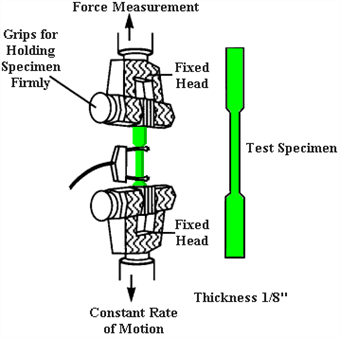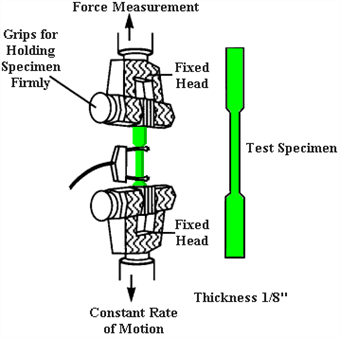

Source: https://www.cliftonsteel.com/knowledge-center/tensile-and-yield-strength

Since elongation and tensile strength both are measured in the same test as the yield strenght, they were removed to prevent leakage, and also the objective is to predict the yield strenght before the steel is tested, only with its composition. Since the formula has unique values for each observation it was also removed.

In [4]:
df.drop(columns=["formula", "elongation", "tensile strength"], inplace=True)

In [5]:
df.shape

(312, 14)

In [6]:
df.duplicated().sum()

0

In [7]:
df.dtypes

c                 float64
mn                float64
si                float64
cr                float64
ni                float64
mo                float64
v                 float64
n                 float64
nb                float64
co                float64
w                 float64
al                float64
ti                float64
yield strength    float64
dtype: object

In [8]:
df.isna().sum()

c                 0
mn                0
si                0
cr                0
ni                0
mo                0
v                 0
n                 0
nb                0
co                0
w                 0
al                0
ti                0
yield strength    0
dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
c,312.00,0.10,0.11,0.00,0.01,0.03,0.18,0.43
mn,312.00,0.15,0.40,0.01,0.01,0.01,0.08,3.00
si,312.00,0.22,0.58,0.01,0.01,0.01,0.11,4.75
cr,312.00,8.04,5.43,0.01,3.10,9.05,12.52,17.50
ni,312.00,8.18,6.34,0.01,0.96,8.50,12.12,21.00
mo,312.00,2.77,1.83,0.02,1.50,2.21,4.09,9.67
v,312.00,0.18,0.45,0.00,0.01,0.01,0.13,4.32
n,312.00,0.01,0.02,0.00,0.00,0.00,0.00,0.15
nb,312.00,0.04,0.16,0.00,0.01,0.01,0.01,2.50
co,312.00,7.01,6.25,0.01,0.01,7.08,13.48,20.10


In [10]:
df.nunique()

c                  36
mn                 48
si                 53
cr                158
ni                150
mo                121
v                  43
n                  11
nb                 14
co                120
w                  16
al                 71
ti                 80
yield strength    270
dtype: int64

# Data Analysis

## Histograms

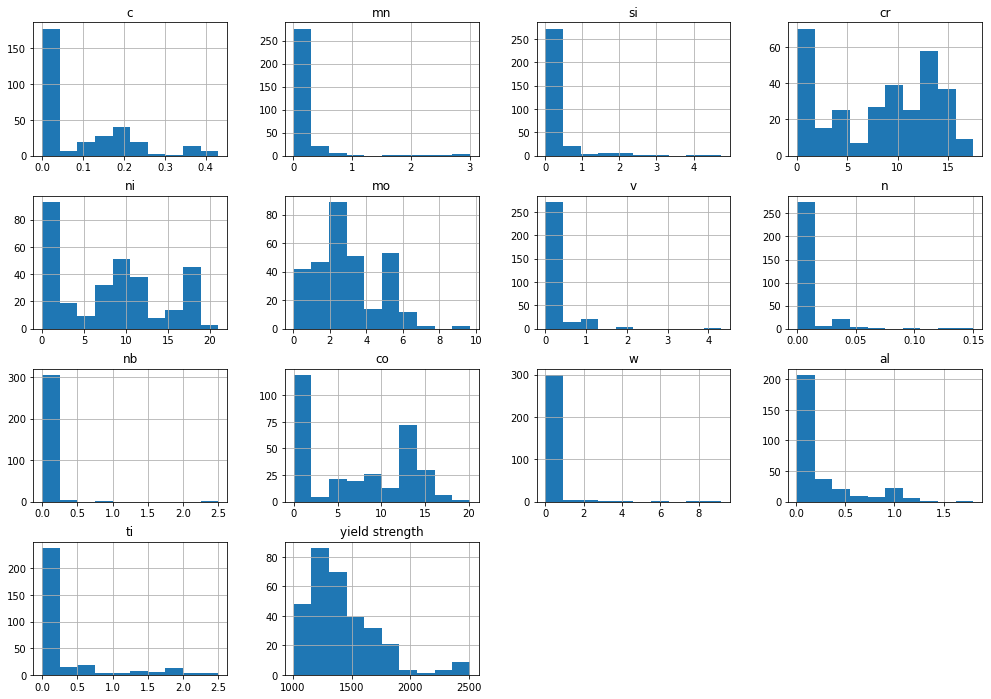

In [11]:
df.hist(figsize=(17,12));

From this we can tell that there are a lot of columns with outliers and none of the columns have a Normal distribution.

## Boxplots

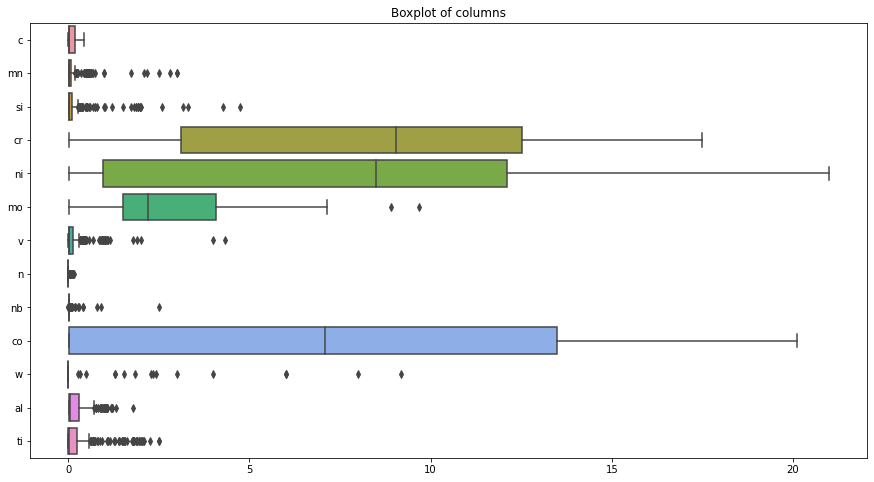

In [12]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df.drop(columns=["yield strength"]), showfliers=True, orient="h")
plt.title("Boxplot of columns");

With the boxplot graph its easier to see all the outliers.

## Correlation

In [13]:
df.corr().style.background_gradient(axis=None)

,c,mn,si,cr,ni,mo,v,n,nb,co,w,al,ti,yield strength
c,1.00,0.02,0.01,0.23,-0.65,0.15,0.32,0.08,0.10,0.42,0.08,-0.41,-0.42,0.15
mn,0.02,1.00,0.02,0.21,-0.13,-0.13,-0.05,0.10,-0.02,-0.18,0.06,-0.02,-0.16,-0.17
si,0.01,0.02,1.00,0.04,0.01,-0.33,-0.11,-0.03,-0.01,-0.03,-0.03,-0.17,-0.17,-0.13
cr,0.23,0.21,0.04,1.00,-0.81,-0.02,-0.12,0.33,-0.07,0.12,0.05,0.09,-0.61,-0.41
ni,-0.65,-0.13,0.01,-0.81,1.00,-0.20,-0.08,-0.35,-0.02,-0.41,-0.12,0.22,0.66,0.25
mo,0.15,-0.13,-0.33,-0.02,-0.20,1.00,0.13,0.29,0.00,0.14,-0.20,0.01,0.01,0.06
v,0.32,-0.05,-0.11,-0.12,-0.08,0.13,1.00,0.07,0.24,0.03,0.04,-0.18,0.01,0.20
n,0.08,0.10,-0.03,0.33,-0.35,0.29,0.07,1.00,-0.03,0.19,0.05,-0.15,-0.17,-0.12
nb,0.10,-0.02,-0.01,-0.07,-0.02,0.00,0.24,-0.03,1.00,-0.02,-0.03,-0.07,0.02,0.03
co,0.42,-0.18,-0.03,0.12,-0.41,0.14,0.03,0.19,-0.02,1.00,0.02,-0.41,-0.14,0.20


In [14]:
df.corrwith(df["yield strength"])

c                 0.15
mn               -0.17
si               -0.13
cr               -0.41
ni                0.25
mo                0.06
v                 0.20
n                -0.12
nb                0.03
co                0.20
w                -0.03
al               -0.04
ti                0.51
yield strength    1.00
dtype: float64

There are some columns, like "mo", "nb" and "w" that have very little correlation with the target feature.

## Yield Strenght vs Cobalt vs Titanium vs Nickel scatterplot

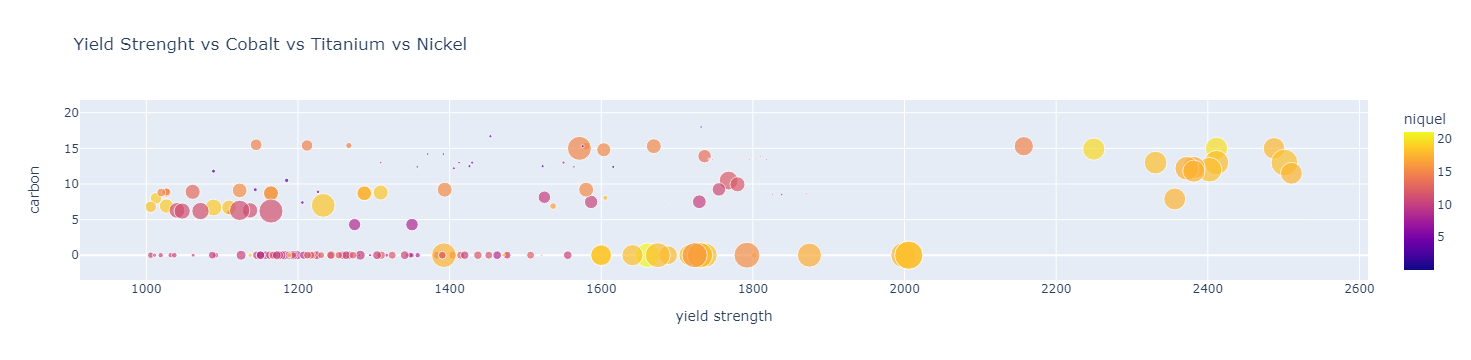

In [56]:
fig = px.scatter(data_frame=df, x="yield strength", y= "co", size= "ti", color= "ni", labels={"ni":"niquel"}, title="Yield Strenght vs Cobalt vs Titanium vs Nickel")
fig.update_layout(yaxis_title="carbon")
fig.show()

# Cleaning Data

In [58]:
# Function from: https://careerfoundry.com/en/blog/data-analytics/how-to-find-outliers/#:~:text=Using%20pandas%20describe()%20to,not%20the%20dataset%20has%20outliers.
def drop_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    df_without_outliers = df[~((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))].dropna()

    return df_without_outliers

In [59]:
print("Initial shape:", df.shape)
print("Shape after dropping outliers:", drop_outliers_IQR(df).shape)

Initial shape: (312, 14)
Shape after dropping outliers: (83, 14)


As seen before, there is a lot of outliers present in this dataset. But if we use the Interquantile Range to remove them, 75% of the data would be lost. So I decided to keep the data as it is. There are other things that can be done to deal with them, like capping the outlier or imputing them with mean or median values.

# Data Splitting

In [19]:
X = df.drop(columns=['yield strength'])
y = df['yield strength']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# Defining Baseline

In [21]:
y_mean = df["yield strength"].mean()
y_pred_mae = [y_mean] * len(df)
acc_baseline = mean_absolute_error(df["yield strength"], y_pred_mae)
print("Baseline MAE:", round(acc_baseline))

Baseline MAE: 229


# Lazy Regressor

It was choosen to use Lazy Regressor to get the best three models and then try to improve them changing hyperparameters.

In [22]:
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train, X_test, y_train, y_test)
models.head()

100%|██████████| 42/42 [00:03<00:00, 11.00it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
BaggingRegressor,0.83,0.86,97.63,0.02
ExtraTreesRegressor,0.79,0.84,105.94,0.15
RandomForestRegressor,0.78,0.82,110.50,0.19
GradientBoostingRegressor,0.76,0.81,113.53,0.06
HistGradientBoostingRegressor,0.76,0.81,115.12,0.32


So the best three models are BagginRegressor, ExtraTreesRegressor and  RandomForestRegressor.

Since there a lot of values with different range scale, a lot of outliers and the data is not normally distributed, I also tried StandardScaler.

In [23]:
X_train_sts, X_test_sts = StandardScaler().fit_transform(X_train), StandardScaler().fit_transform(X_test)
reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
models,predictions = reg.fit(X_train_sts, X_test_sts, y_train, y_test)
models.head()

100%|██████████| 42/42 [00:01<00:00, 22.12it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
HistGradientBoostingRegressor,0.69,0.75,130.10,0.27
LGBMRegressor,0.68,0.75,132.50,0.05
KNeighborsRegressor,0.64,0.71,140.88,0.01
RandomForestRegressor,0.56,0.65,155.68,0.18
ExtraTreesRegressor,0.53,0.63,159.55,0.13


But the results were way worse then before.

# Model 1: Random Forest

### Setting parameters:

In [24]:
params = {
    "n_estimators": range(450,1000,100),
    "max_depth": range(20,61,5),
    "criterion": ["squared_error", "absolute_error"],
    "min_samples_split": [2,4],
    "min_samples_leaf": [1,2,4]
}

### Building the model:

In [25]:
model_rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    params,
    cv=5,
    n_jobs=-1,
    n_iter=35,
    scoring=["neg_mean_absolute_error", "r2"],
    refit="neg_mean_absolute_error",
    verbose=1
)

### Fitting:

In [26]:
model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(20, 61, 5),
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4],
                                        'n_estimators': range(450, 1000, 100)},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'], verbose=1)

### Getting results:

In [27]:
cv_results = pd.DataFrame(model_rf.cv_results_)
cv_results.sort_values("rank_test_neg_mean_absolute_error").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
31,1.42,0.06,0.07,0.00,750,2,1,25,squared_error,"{'n_estimators': 750, 'min_samples_split': 2, ...",-90.47,-90.92,-127.71,-84.63,-89.73,-96.69,15.67,1,0.87,0.77,0.73,0.72,0.85,0.79,0.06,8
29,1.63,0.14,0.08,0.00,850,2,1,35,squared_error,"{'n_estimators': 850, 'min_samples_split': 2, ...",-89.71,-91.73,-127.66,-84.51,-89.90,-96.70,15.66,2,0.87,0.77,0.73,0.72,0.85,0.79,0.06,11
8,1.61,0.05,0.08,0.01,850,2,1,40,squared_error,"{'n_estimators': 850, 'min_samples_split': 2, ...",-89.71,-91.73,-127.66,-84.51,-89.90,-96.70,15.66,2,0.87,0.77,0.73,0.72,0.85,0.79,0.06,11
33,1.41,0.04,0.09,0.02,750,2,1,35,squared_error,"{'n_estimators': 750, 'min_samples_split': 2, ...",-90.45,-90.92,-127.76,-84.63,-89.75,-96.70,15.69,4,0.87,0.77,0.73,0.72,0.85,0.79,0.06,7
16,1.27,0.04,0.07,0.01,650,2,1,25,squared_error,"{'n_estimators': 650, 'min_samples_split': 2, ...",-90.53,-91.23,-128.06,-84.55,-89.82,-96.84,15.79,5,0.87,0.77,0.72,0.72,0.85,0.79,0.06,13


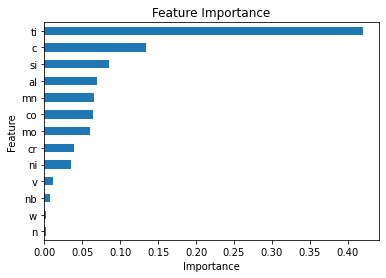

In [28]:
# Get feature names from training data
features = X_train.columns
# Extract importances from model
importances = model_rf.best_estimator_.feature_importances_
# Create a series with feature names and importances
feat_imp = pd.Series(importances, index=features)
# Plot 10 most important features
feat_imp.sort_values().plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

It seems that there are a lot of features that could be scrapped.

### Evaluating the model:

In [29]:
mae_rf_train = mean_absolute_error(y_train, model_rf.predict(X_train))
mae_rf_test = mean_absolute_error(y_test, model_rf.predict(X_test))

print("Random Forest:")
print("Training Mean Absolute Error:", round(mae_rf_train, 4))
print("Test Mean Absolute Error:", round(mae_rf_test, 4))
print("Baseline Mean Absolute Error:", round(acc_baseline, 4))

Random Forest:
Training Mean Absolute Error: 33.9818
Test Mean Absolute Error: 78.4533
Baseline Mean Absolute Error: 229.3743


In [30]:
r2_rf_train = r2_score(y_train, model_rf.predict(X_train))
r2_rf_test = r2_score(y_test, model_rf.predict(X_test))

print("Random Forest:")
print("Training R2:", round(r2_rf_train, 4))
print("Test R2:", round(r2_rf_test, 4))

Random Forest:
Training R2: 0.9758
Test R2: 0.8249


# Model 2: Bagging Regressor

In [31]:
params_br = {
    "n_estimators": range(5,50,5),
}

In [32]:
model_br = GridSearchCV(
    BaggingRegressor(random_state=42),
    params_br,
    cv=5,
    n_jobs=-1,
    scoring=["neg_mean_absolute_error", "r2"],
    refit="neg_mean_absolute_error",
    verbose=1
)

In [33]:
model_br.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': range(5, 50, 5)},
             refit='neg_mean_absolute_error',
             scoring=['neg_mean_absolute_error', 'r2'], verbose=1)

In [34]:
cv_results = pd.DataFrame(model_br.cv_results_)
cv_results.sort_values("rank_test_neg_mean_absolute_error").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
7,0.09,0.00,0.01,0.00,40,{'n_estimators': 40},-91.56,-90.12,-129.74,-86.19,-86.40,-96.80,16.60,1,0.88,0.77,0.72,0.71,0.85,0.79,0.07,3
8,0.09,0.01,0.01,0.00,45,{'n_estimators': 45},-92.01,-89.74,-129.98,-85.37,-88.05,-97.03,16.62,2,0.87,0.77,0.72,0.72,0.85,0.79,0.07,1
6,0.09,0.02,0.01,0.00,35,{'n_estimators': 35},-93.01,-90.61,-130.29,-86.74,-85.64,-97.26,16.73,3,0.87,0.77,0.72,0.71,0.85,0.79,0.07,2
5,0.09,0.02,0.01,0.00,30,{'n_estimators': 30},-92.33,-91.32,-132.07,-89.14,-85.28,-98.03,17.19,4,0.87,0.76,0.72,0.70,0.85,0.78,0.07,4
4,0.08,0.01,0.01,0.00,25,{'n_estimators': 25},-88.82,-93.65,-132.60,-91.74,-84.01,-98.17,17.52,5,0.88,0.76,0.71,0.68,0.85,0.78,0.08,5


In [35]:
mae_br_train = mean_absolute_error(y_train, model_br.predict(X_train))
mae_br_test = mean_absolute_error(y_test, model_br.predict(X_test))

print("Bagging Regressor:")
print("Training Mean Absolute Error:", round(mae_br_train, 4))
print("Test Mean Absolute Error:", round(mae_br_test, 4))
print("Baseline Mean Absolute Error:", round(acc_baseline, 4))

Random Forest:
Training Mean Absolute Error: 35.4595
Test Mean Absolute Error: 78.2485
Baseline Mean Absolute Error: 229.3743


In [36]:
r2_br_train = r2_score(y_train, model_br.predict(X_train))
r2_br_test = r2_score(y_test, model_br.predict(X_test))

print("Bagging Regressor:")
print("Training R2:", round(r2_br_train, 4))
print("Test R2:", round(r2_br_test, 4))

Bagging Regressor:
Training R2: 0.9736
Test R2: 0.8355


# Model 3: ExtraTreesRegressor

In [37]:
params_et = {
    "n_estimators": range(100,1001,100),
    "max_depth": range(20,61,5),
    "criterion": ["squared_error", "absolute_error"],
    "min_samples_split": [2,3],
    "min_samples_leaf": [1,2,3]
}

In [38]:
model_et = RandomizedSearchCV(
    ExtraTreesRegressor(random_state=42),
    params_et,
    cv=5,
    n_jobs=-1,
    scoring=["neg_mean_absolute_error", "r2"],
    n_iter=35,
    refit="neg_mean_absolute_error",
    verbose=1
)

In [39]:
model_et.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


RandomizedSearchCV(cv=5, estimator=ExtraTreesRegressor(random_state=42),
                   n_iter=35, n_jobs=-1,
                   param_distributions={'criterion': ['squared_error',
                                                      'absolute_error'],
                                        'max_depth': range(20, 61, 5),
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3],
                                        'n_estimators': range(100, 1001, 100)},
                   refit='neg_mean_absolute_error',
                   scoring=['neg_mean_absolute_error', 'r2'], verbose=1)

In [40]:
cv_results = pd.DataFrame(model_et.cv_results_)
cv_results.sort_values("rank_test_neg_mean_absolute_error").head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
4,1.38,0.08,0.09,0.00,1000,2,1,40,squared_error,"{'n_estimators': 1000, 'min_samples_split': 2,...",-80.40,-88.59,-105.85,-86.07,-77.60,-87.71,9.88,1,0.91,0.80,0.81,0.69,0.88,0.82,0.08,19
26,0.81,0.03,0.06,0.00,600,2,1,45,squared_error,"{'n_estimators': 600, 'min_samples_split': 2, ...",-79.76,-89.11,-105.50,-86.55,-77.93,-87.77,9.78,2,0.91,0.79,0.81,0.68,0.88,0.82,0.08,20
16,0.58,0.02,0.05,0.01,400,2,1,40,squared_error,"{'n_estimators': 400, 'min_samples_split': 2, ...",-80.95,-88.98,-106.00,-86.28,-78.65,-88.17,9.64,3,0.91,0.79,0.81,0.68,0.88,0.82,0.08,21
12,1.29,0.05,0.09,0.00,1000,3,1,35,squared_error,"{'n_estimators': 1000, 'min_samples_split': 3,...",-80.37,-89.82,-105.90,-87.02,-78.05,-88.23,9.82,4,0.91,0.79,0.81,0.68,0.88,0.81,0.08,22
29,1.10,0.02,0.09,0.00,1000,3,2,60,squared_error,"{'n_estimators': 1000, 'min_samples_split': 3,...",-78.35,-89.93,-112.64,-83.14,-78.82,-88.58,12.73,5,0.92,0.79,0.81,0.72,0.88,0.82,0.07,1


In [41]:
mae_et_train = mean_absolute_error(y_train, model_et.predict(X_train))
mae_et_test = mean_absolute_error(y_test, model_et.predict(X_test))

print("Extra Trees Regressor:")
print("Training Mean Absolute Error:", round(mae_et_train, 4))
print("Test Mean Absolute Error:", round(mae_et_test, 4))
print("Baseline Mean Absolute Error:", round(acc_baseline, 4))

Extra Trees Regressor:
Training Mean Absolute Error: 0.0
Test Mean Absolute Error: 71.826
Baseline Mean Absolute Error: 229.3743


In [42]:
r2_et_train = r2_score(y_train, model_et.predict(X_train))
r2_et_test = r2_score(y_test, model_et.predict(X_test))

print("Extra Trees Regressor:")
print("Training R2:", round(r2_et_train, 4))
print("Test R2:", round(r2_et_test, 4))

Bagging Regressor:
Training R2: 1.0
Test R2: 0.844


# Model 4: Voting Regressor

In [44]:
pipe = VotingRegressor(estimators=[("rf", model_rf.best_estimator_),
                                  ("et" ,model_et.best_estimator_),
                                  ("br" ,model_br.best_estimator_)])
                          

In [45]:
params_vr = {
    "weights": [None, [2,3,2], [2,1,2]]
}

In [46]:
model_vr = GridSearchCV(
    pipe,
    params_vr,
    cv=5,
    n_jobs=-1,
    scoring=["neg_mean_absolute_error", "r2"],
    refit="neg_mean_absolute_error",
    verbose=1
)

In [47]:
model_vr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=VotingRegressor(estimators=[('rf',
                                                    RandomForestRegressor(max_depth=25,
                                                                          n_estimators=750,
                                                                          random_state=42)),
                                                   ('et',
                                                    ExtraTreesRegressor(max_depth=40,
                                                                        n_estimators=1000,
                                                                        random_state=42)),
                                                   ('br',
                                                    BaggingRegressor(n_estimators=40,
                                                                     random_state=42))]),
             n_jobs=-1, param_grid={'weights': [None, [2, 3, 2], [2, 1, 2]]},
            

In [48]:
cv_results = pd.DataFrame(model_vr.cv_results_)
cv_results.sort_values('rank_test_neg_mean_absolute_error').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_weights,params,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
1,2.90,0.07,0.24,0.03,"[2, 3, 2]","{'weights': [2, 3, 2]}",-85.30,-85.69,-117.18,-82.63,-80.18,-90.20,13.64,1,0.90,0.80,0.77,0.72,0.87,0.81,0.07,1
0,2.85,0.04,0.22,0.04,None,{'weights': None},-86.12,-85.94,-119.72,-83.11,-81.47,-91.27,14.33,2,0.89,0.79,0.76,0.72,0.87,0.81,0.07,2
2,2.33,0.44,0.16,0.08,"[2, 1, 2]","{'weights': [2, 1, 2]}",-87.72,-87.28,-123.29,-83.94,-83.77,-93.20,15.14,3,0.89,0.79,0.74,0.72,0.86,0.80,0.06,3


In [49]:
mae_vr_train = mean_absolute_error(y_train, model_vr.predict(X_train))
mae_vr_test = mean_absolute_error(y_test, model_vr.predict(X_test))

print("Voting Regressor:")
print("Training Mean Absolute Error:", round(mae_vr_train, 4))
print("Test Mean Absolute Error:", round(mae_vr_test, 4))
print("Baseline Mean Absolute Error:", round(acc_baseline, 4))

Voting Regressor:
Training Mean Absolute Error: 19.625
Test Mean Absolute Error: 72.2578
Baseline Mean Absolute Error: 229.3743


In [50]:
r2_vr_train = r2_score(y_train, model_vr.predict(X_train))
r2_vr_test = r2_score(y_test, model_vr.predict(X_test))

print("Voting Regressor:")
print("Training R2:", round(r2_vr_train, 4))
print("Test R2:", round(r2_vr_test, 4))

Voting Regressor:
Training R2: 0.9919
Test R2: 0.8534


# Conclusion

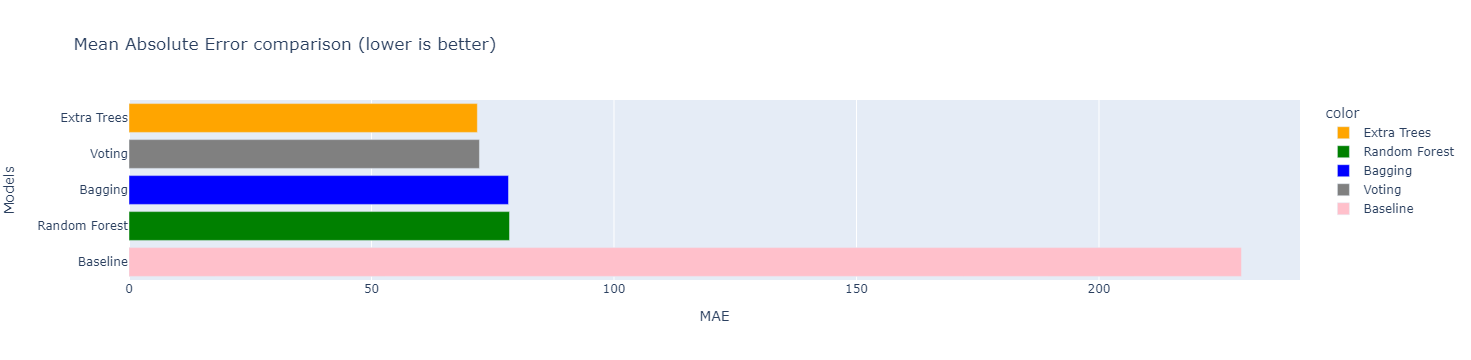

In [51]:
fig = px.bar(y=["Extra Trees", "Random Forest", "Bagging", "Voting", "Baseline"], 
             x=[mae_et_test, mae_rf_test, mae_br_test, mae_vr_test, acc_baseline], 
             color=["Extra Trees", "Random Forest", "Bagging", "Voting", "Baseline"],
             color_discrete_map={"Extra Trees": "orange",
                                "Random Forest": "green",
                                "Bagging": "blue",
                                "Voting": "grey",
                                "Baseline": "pink"},
            title="Mean Absolute Error comparison (lower is better)")
fig.update_layout(yaxis={'categoryorder':'total descending'}, xaxis_title="MAE", yaxis_title="Models")
fig.show()

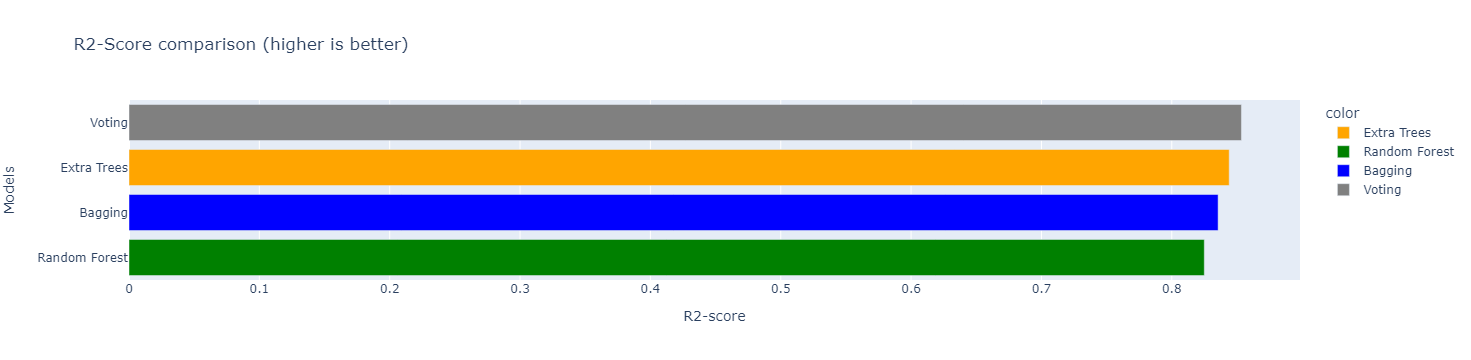

In [52]:
fig = px.bar(y=["Extra Trees", "Random Forest", "Bagging", "Voting"], 
             x=[r2_et_test, r2_rf_test, r2_br_test, r2_vr_test], 
             color=["Extra Trees", "Random Forest", "Bagging", "Voting"], 
             color_discrete_map={"Extra Trees": "orange",
                                "Random Forest": "green",
                                "Bagging": "blue",
                                "Voting": "grey",},
            title="R2-Score comparison (higher is better)")
fig.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title="R2-score", yaxis_title="Models")
fig.show()

* The best model for mean absolute error score is Extra Trees Regressor.
* The best model for R2-score is the Voting Regressor.
* The results can be improved with feature selection.
* There are outliers handling that can be tested to improve results.

# Upvote if you liked the Notebook!